In [7]:
import kagglehub

# Download latest version of the PlantVillage dataset
path = kagglehub.dataset_download("moazeldsokyx/plantvillage")

print("✅ Dataset downloaded successfully!")
print("📂 Path to dataset files:", path)


✅ Dataset downloaded successfully!
📂 Path to dataset files: /kaggle/input/plantvillage


In [8]:
import os

base_dir = "/kaggle/input/plantvillage/dataset"

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

print("📂 Train dir:", train_dir)
print("📂 Test dir:", test_dir)


📂 Train dir: /kaggle/input/plantvillage/dataset/train
📂 Test dir: /kaggle/input/plantvillage/dataset/test


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 16504 images belonging to 15 classes.
Found 2064 images belonging to 15 classes.


In [10]:
# ================================
# 1. Setup & Imports
# ================================
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image

# ================================
# 2. Dataset Paths
# ================================
base_dir = "/kaggle/input/plantvillage/dataset"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

print("📂 Train dir:", train_dir)
print("📂 Test dir:", test_dir)

# ================================
# 3. Data Generators (for CNN)
# ================================
img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

# ================================
# 4. CNN Model
# ================================
cnn = models.Sequential([
    layers.Input(shape=(128,128,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

# Train CNN
history_cnn = cnn.fit(train_gen, validation_data=test_gen, epochs=5)

# ================================
# 5. CNN Evaluation
# ================================
y_pred_cnn = cnn.predict(test_gen)
y_pred_cnn_classes = y_pred_cnn.argmax(axis=1)
y_true_cnn = test_gen.classes

print("📊 CNN Classification Report:")
print(classification_report(y_true_cnn, y_pred_cnn_classes, target_names=list(test_gen.class_indices.keys())))

# ================================
# 6. Feature Extraction for Tabular NN
# ================================
def extract_features(img_path):
    img = Image.open(img_path).resize((128,128))
    img_arr = np.array(img)

    # RGB mean & std
    features = []
    for i in range(3):  # R, G, B
        channel = img_arr[:,:,i]
        features.append(channel.mean())
        features.append(channel.std())

    # Grayscale histogram (16 bins)
    gray = img.convert("L")
    hist = np.histogram(np.array(gray), bins=16, range=(0,256))[0]
    hist = hist / hist.sum()
    features.extend(hist)

    return features

X, y = [], []
class_labels = os.listdir(train_dir)

for label_idx, label in enumerate(class_labels):
    class_folder = os.path.join(train_dir, label)
    for img_name in os.listdir(class_folder)[:200]:  # limit to speed up
        img_path = os.path.join(class_folder, img_name)
        try:
            feats = extract_features(img_path)
            X.append(feats)
            y.append(label_idx)
        except:
            continue

X = np.array(X)
y = np.array(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ================================
# 7. Tabular NN
# ================================
tab_nn = Sequential([
    Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(32, activation="relu"),
    Dense(len(class_labels), activation="softmax")
])

tab_nn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
tab_nn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Evaluate
y_pred_tab = tab_nn.predict(X_test).argmax(axis=1)

print("📊 Tabular NN Classification Report:")
print(classification_report(y_test, y_pred_tab, target_names=class_labels))


📂 Train dir: /kaggle/input/plantvillage/dataset/train
📂 Test dir: /kaggle/input/plantvillage/dataset/test
Found 16504 images belonging to 15 classes.
Found 2064 images belonging to 15 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,575 (12.61 MB)

 Trainable params: 3,306,575 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 604s 1s/step - accuracy: 0.4746 - loss: 1.6314 - val_accuracy: 0.7762 - val_loss: 0.6420
Epoch 2/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 552s 1s/step - accuracy: 0.8273 - loss: 0.5165 - val_accuracy: 0.8668 - val_loss: 0.3849
Epoch 3/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.9148 - loss: 0.2633 - val_accuracy: 0.8924 - val_loss: 0.3026
Epoch 4/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 552s 1s/step - accuracy: 0.9398 - loss: 0.1731 - val_accuracy: 0.9089 - val_loss: 0.2748
Epoch 5/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 537s 1s/step - accuracy: 0.9619 - loss: 0.1109 - val_accuracy: 0.9133 - val_loss: 0.2827
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 322ms/step
📊 CNN Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.91      0.84      0.88       100
                     Pepper__bell___healthy       0.95      0.97      0.96       148
                      Potato___Ea

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1039 - loss: 2.6669 - val_accuracy: 0.2650 - val_loss: 2.3891
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3002 - loss: 2.2727 - val_accuracy: 0.3333 - val_loss: 2.1095
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3810 - loss: 1.9868 - val_accuracy: 0.3812 - val_loss: 1.9094
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4526 - loss: 1.7769 - val_accuracy: 0.4188 - val_loss: 1.7580
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5021 - loss: 1.6327 - val_accuracy: 0.4803 - val_loss: 1.6249
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5269 - loss: 1.5212 - val_accuracy: 0.4974 - val_loss: 1.5328
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5619 - loss: 1.4381 - val_accuracy: 0.5368 - val_loss: 1.4594
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5664 - loss: 1.3937 - val_accuracy: 0.5538 - val_loss: 1.4073
Epo

In [11]:
tab_nn = Sequential([
    Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(32, activation="relu"),
    Dense(len(class_labels), activation="softmax")
])
from tensorflow.keras.layers import Dropout

tab_nn = Sequential([
    Dense(256, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(len(class_labels), activation="softmax")
])

tab_nn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history_tab = tab_nn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,  # more epochs
    batch_size=32,
    verbose=1
)

# Evaluate
y_pred_tab = tab_nn.predict(X_test).argmax(axis=1)

print("📊 Improved Tabular NN Classification Report:")
print(classification_report(y_test, y_pred_tab, target_names=class_labels))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1573 - loss: 2.5928 - val_accuracy: 0.3231 - val_loss: 2.1328
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3532 - loss: 2.0495 - val_accuracy: 0.4188 - val_loss: 1.7733
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4488 - loss: 1.7551 - val_accuracy: 0.5231 - val_loss: 1.5244
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4927 - loss: 1.5806 - val_accuracy: 0.5692 - val_loss: 1.3852
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5261 - loss: 1.4510 - val_accuracy: 0.6017 - val_loss: 1.2824
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5698 - loss: 1.3126 - val_accuracy: 0.6205 - val_loss: 1.2010
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5709 - loss: 1.2370 - val_accuracy: 0.6325 - val_loss: 1.1457
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5978 - loss: 1.2086 - val_accuracy: 0.6752 - val_loss

In [12]:
from scipy.stats import skew, kurtosis

def extract_features(img_path):
    img = Image.open(img_path).resize((128,128))
    img_arr = np.array(img)

    features = []

    # --- RGB statistics ---
    for i in range(3):  # R, G, B
        channel = img_arr[:,:,i].flatten()
        features.append(channel.mean())
        features.append(channel.std())
        features.append(np.var(channel))
        features.append(skew(channel))
        features.append(kurtosis(channel))

        # RGB histogram (16 bins)
        hist = np.histogram(channel, bins=16, range=(0,256))[0]
        hist = hist / hist.sum()
        features.extend(hist)

    # --- Grayscale histogram (32 bins) ---
    gray = img.convert("L")
    hist_gray = np.histogram(np.array(gray), bins=32, range=(0,256))[0]
    hist_gray = hist_gray / hist_gray.sum()
    features.extend(hist_gray)

    return features


In [13]:
from tensorflow.keras.layers import Dropout

tab_nn = Sequential([
    Dense(512, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dense(len(class_labels), activation="softmax")
])

tab_nn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history_tab = tab_nn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,   # train longer
    batch_size=64,
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1934 - loss: 2.5181 - val_accuracy: 0.3111 - val_loss: 2.0947
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3401 - loss: 1.9991 - val_accuracy: 0.4205 - val_loss: 1.7652
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4684 - loss: 1.6804 - val_accuracy: 0.5402 - val_loss: 1.4586
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5092 - loss: 1.4762 - val_accuracy: 0.5761 - val_loss: 1.3612
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5678 - loss: 1.3680 - val_accuracy: 0.6017 - val_loss: 1.2441
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5848 - loss: 1.2251 - val_accuracy: 0.6068 - val_loss: 1.2057
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6050 - loss: 1.1800 - val_accuracy: 0.6256 - val_loss: 1.1684
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6135 - loss: 1.1235 - val_accuracy: 0.6325 - val_loss: 1.1126


In [14]:
y_pred_tab = tab_nn.predict(X_test).argmax(axis=1)

print("📊 Tabular NN Report:")
print(classification_report(y_test, y_pred_tab, target_names=class_labels))


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
📊 Tabular NN Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.70      0.79      0.75        39
                           Potato___healthy       0.82      0.82      0.82        28
                           Tomato_Leaf_Mold       0.84      0.86      0.85        49
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.68      0.75      0.71        36
                      Tomato_Bacterial_spot       0.88      0.76      0.82        38
                  Tomato_Septoria_leaf_spot       0.73      0.63      0.68        35
                             Tomato_healthy       0.84      0.86      0.85        37
Tomato_Spider_mites_Two_spotted_spider_mite       0.74      0.70      0.72        40
                        Tomato_Early_blight       0.64      0.60      0.62        30
                        Tomato__Target_Spot       0.82      0.74      0.78        42
    

In [15]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# --- CNN evaluation ---
y_pred_cnn = cnn.predict(test_gen).argmax(axis=1)
y_true_cnn = test_gen.classes

cnn_acc = accuracy_score(y_true_cnn, y_pred_cnn)
cnn_prec = precision_score(y_true_cnn, y_pred_cnn, average="weighted")
cnn_rec = recall_score(y_true_cnn, y_pred_cnn, average="weighted")
cnn_f1 = f1_score(y_true_cnn, y_pred_cnn, average="weighted")

# --- Tabular NN evaluation ---
y_pred_tab = tab_nn.predict(X_test).argmax(axis=1)

tab_acc = accuracy_score(y_test, y_pred_tab)
tab_prec = precision_score(y_test, y_pred_tab, average="weighted")
tab_rec = recall_score(y_test, y_pred_tab, average="weighted")
tab_f1 = f1_score(y_test, y_pred_tab, average="weighted")

# --- Build result table ---
results = pd.DataFrame({
    "Model": ["CNN", "Tabular NN"],
    "Accuracy": [cnn_acc, tab_acc],
    "Precision": [cnn_prec, tab_prec],
    "Recall": [cnn_rec, tab_rec],
    "F1-score": [cnn_f1, tab_f1]
})

print("📊 Model Performance Comparison")
print(results)


65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 306ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
📊 Model Performance Comparison
        Model  Accuracy  Precision    Recall  F1-score
0         CNN  0.913275   0.917625  0.913275  0.913964
1  Tabular NN  0.777778   0.778873  0.777778  0.775470


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


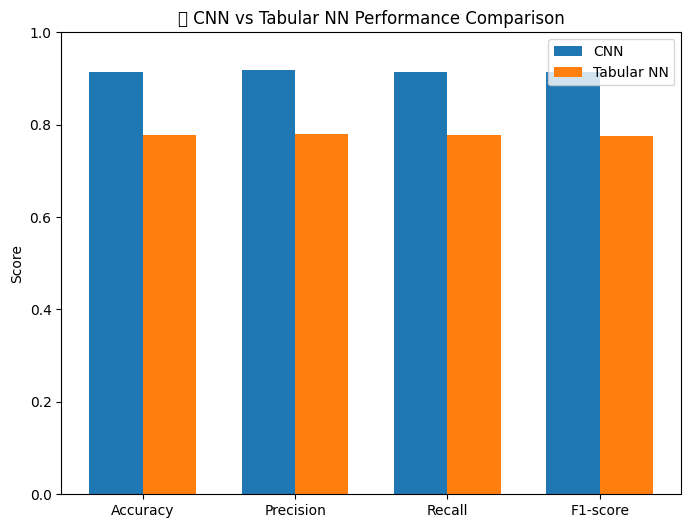

In [16]:
import matplotlib.pyplot as plt

# Metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
cnn_scores = [cnn_acc, cnn_prec, cnn_rec, cnn_f1]
tab_scores = [tab_acc, tab_prec, tab_rec, tab_f1]

x = np.arange(len(metrics))  # positions
width = 0.35  # bar width

plt.figure(figsize=(8,6))
plt.bar(x - width/2, cnn_scores, width, label="CNN")
plt.bar(x + width/2, tab_scores, width, label="Tabular NN")

# Labels & formatting
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("📊 CNN vs Tabular NN Performance Comparison")
plt.legend()
plt.show()


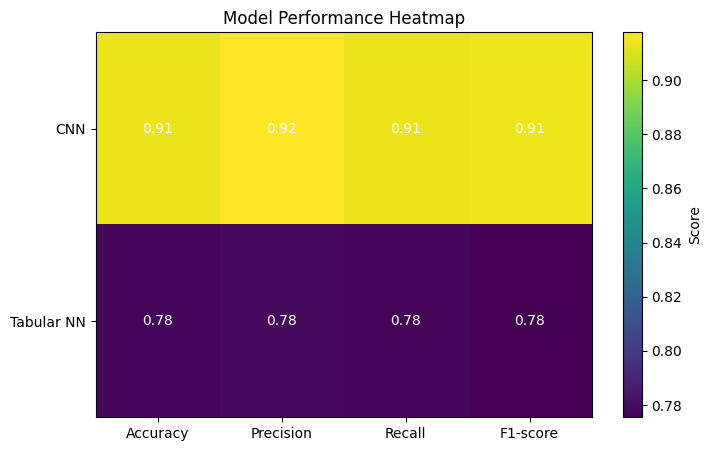

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Data
results = {
    "CNN": [cnn_acc, cnn_prec, cnn_rec, cnn_f1],
    "Tabular NN": [tab_acc, tab_prec, tab_rec, tab_f1]
}

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

# Convert to array
data = np.array(list(results.values()))

# Plot heatmap
plt.figure(figsize=(8,5))
plt.imshow(data, cmap="viridis", aspect="auto")

# Show values on heatmap
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.text(j, i, f"{data[i, j]:.2f}", ha="center", va="center", color="white")

# Labels
plt.xticks(np.arange(len(metrics)), metrics)
plt.yticks(np.arange(len(results)), list(results.keys()))
plt.colorbar(label="Score")
plt.title("Model Performance Heatmap")
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


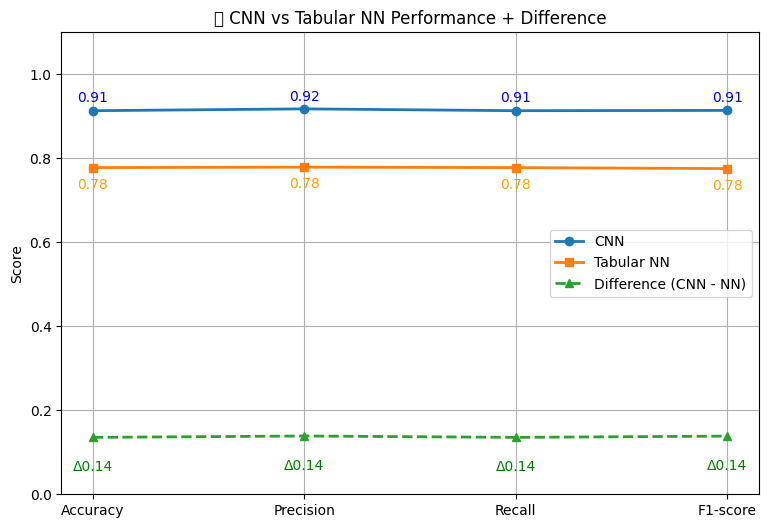

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
cnn_scores = [cnn_acc, cnn_prec, cnn_rec, cnn_f1]
tab_scores = [tab_acc, tab_prec, tab_rec, tab_f1]

x = np.arange(len(metrics))  # X positions

plt.figure(figsize=(9,6))

# CNN line
plt.plot(x, cnn_scores, marker='o', label="CNN", linewidth=2)

# Tabular NN line
plt.plot(x, tab_scores, marker='s', label="Tabular NN", linewidth=2)

# Difference line (CNN - Tabular NN)
diff_scores = np.array(cnn_scores) - np.array(tab_scores)
plt.plot(x, diff_scores, marker='^', linestyle="--", label="Difference (CNN - NN)", linewidth=2)

# Annotate values
for i, val in enumerate(cnn_scores):
    plt.text(x[i], val+0.02, f"{val:.2f}", ha="center", color="blue")
for i, val in enumerate(tab_scores):
    plt.text(x[i], val-0.05, f"{val:.2f}", ha="center", color="orange")
for i, val in enumerate(diff_scores):
    plt.text(x[i], val-0.08, f"Δ{val:.2f}", ha="center", color="green")

# Labels & formatting
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.title("📈 CNN vs Tabular NN Performance + Difference")
plt.legend()
plt.grid(True)
plt.show()
